In [1]:
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm
import pymc.sampling_jax
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, precision_score, recall_score, roc_auc_score, accuracy_score, auc
from sklearn.calibration import CalibrationDisplay
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

%load_ext watermark
%watermark -n -u -v -iv -w -p sklearn

Last updated: Wed Jun 19 2024

Python implementation: CPython
Python version       : 3.9.18
IPython version      : 8.12.0

sklearn: 1.4.0

numpy     : 1.26.3
pymc      : 5.10.3
arviz     : 0.17.0
pandas    : 2.2.0
seaborn   : 0.13.2
matplotlib: 3.8.2

Watermark: 2.4.3



In [2]:
import os

os.chdir("D:/Last_attempt/")

In [3]:
df = pd.read_csv("D:/Last_attempt/proximity_data.csv")
df.head()

,experiment,duration,seeder,Cap2,time_between_0.05_and_0.5m,time_between_0.5_and_1m,time_between_1_and_2m,time_above_2m,infected
0,1,1,436,100,2.783333,10.600000,23.483333,25.850000,0
1,1,1,436,116,4.500000,20.983333,23.216667,13.916667,0
2,1,1,436,255,6.200000,20.900000,27.200000,8.416667,0
3,1,1,436,449,17.016667,20.733333,15.933333,9.050000,0
4,1,1,436,3008,0.183333,1.033333,9.700000,51.816667,0


In [4]:
df['infected'] = df['infected'].astype('category')

In [5]:
y = df["infected"].to_numpy()
t0 = df['time_between_0.05_and_0.5m'].to_numpy()
t1 = df['time_between_0.5_and_1m'].to_numpy()
t2 = df['time_between_1_and_2m'].to_numpy()
t3 = df['time_above_2m'].to_numpy()



1. model 1:

$$p_i = 1 - (1-p)^{t_0} \cdot (1-\alpha_{1} p)^{t_1} \cdot (1-\alpha_{2} p)^{t_2} \cdot (1-\alpha_{3} p)^{t_3} \qquad where \qquad \alpha_3 < \alpha_2 < \alpha_1, \quad \alpha_1 < 1$$



2. model 2: Logit of $z_i$:
$$
p_i = \text{{logit}}(z_i) = \log\left(\frac{{z_i}}{{1 - z_i}}\right)
$$

3. model 3: Sigmoid of $z_i$:
$$
p_i = \sigma(z_i) = \frac{{1}}{{1 + e^{-z_i}}}
$$ \\ \\



$$z_i = \beta_0 + \alpha_1\times t_1 + \alpha_2 \times t_2 + \alpha_3 \times t_3 + \alpha_4 \times t_4$$
    
Note: In the equations, $\sigma$ represents the sigmoid function and $e$ represents the base of the natural logarithm.




# Sigmoid model

In [6]:
# ML coefficients

beta_0_ml = -3.6461765972057743 
alpha_1_ml = -0.013405425809074853 
alpha_2_ml = 0.004965173526324209
alpha_3_ml = 0.00033094218905139745 
alpha_4_ml = 0.0016462064701024469

In [18]:
%%time
with pm.Model() as model_sigmoid:
    # Priors
    beta = pm.Normal('beta', mu=0, sigma=1)
    alpha_1 = pm.Uniform('alpha_1', 0, 1)
    alpha_2 = pm.Uniform('alpha_2', 0, alpha_1)
    alpha_3 = pm.Uniform('alpha_3', 0, alpha_2)
    alpha_4 = pm.Uniform('alpha_4', 0, alpha_3)

    z_i =  beta + alpha_1*t0 + alpha_2*t1 + alpha_3*t2 + alpha_4*t3

    # Logistic regression
    p = 1 - pm.math.sigmoid(z_i)
    p_i = pm.Deterministic('p', p)

    # Likelihood
    y_true = pm.Bernoulli('y_obs', p=p, observed=y)

CPU times: total: 0 ns
Wall time: 23 ms


In [19]:
%%time
with model_sigmoid:
    trace_sigmoid = pm.sampling.jax.sample_blackjax_nuts(draws=10000, tune=1000, chains=10, target_accept=0.95)

Compiling...
Compilation time = 0:00:05.347170
Sampling...
Sampling time = 0:00:05.682315
Transforming variables...
Transformation time = 0:00:00.301288


CPU times: total: 10.1 s
Wall time: 11.4 s


In [20]:
az.summary(trace_sigmoid, round_to=4)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta,0.9374,0.2883,0.3858,1.4734,0.0011,0.0008,73135.6931,61268.5390,1.0000
alpha_1,0.0032,0.0044,0.0000,0.0110,0.0000,0.0000,46293.8384,46751.8651,1.0001
alpha_2,0.0004,0.0006,0.0000,0.0015,0.0000,0.0000,62435.5489,56093.3482,1.0001
alpha_3,0.0001,0.0001,0.0000,0.0003,0.0000,0.0000,67898.0972,57005.3408,1.0000
alpha_4,0.0000,0.0000,0.0000,0.0001,0.0000,0.0000,78219.3774,59302.5422,1.0000
...,...,...,...,...,...,...,...,...,...
p[59],0.2743,0.0545,0.1721,0.3760,0.0002,0.0001,76669.6613,67982.0704,1.0000
p[60],0.2804,0.0561,0.1756,0.3854,0.0002,0.0001,74309.8633,64524.4006,1.0001
p[61],0.2681,0.0538,0.1688,0.3698,0.0002,0.0001,79162.9083,69174.7292,1.0000
p[62],0.2508,0.0551,0.1497,0.3561,0.0002,0.0001,86512.5006,76895.8022,1.0001


In [21]:
az.plot_posterior(trace_sigmoid, hdi_prob=.95);

d:\anaconda3\envs\tf\lib\site-packages\arviz\plots\plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (69) in plot_posterior, generating only 40 plots
  warnings.warn(


In [22]:
samples = trace_sigmoid.posterior.stack(sample=("chain", "draw"))
p_list_df = pd.DataFrame(samples['p'].values)
p_list_df.head()

,0,1,2,3,4,5,6,7,8,9,...,99990,99991,99992,99993,99994,99995,99996,99997,99998,99999
0,0.338785,0.258353,0.339331,0.244752,0.226820,0.197654,0.285095,0.285996,0.259906,0.244559,...,0.294155,0.281215,0.220704,0.199497,0.189077,0.254345,0.329414,0.191202,0.400765,0.156314
1,0.329139,0.257232,0.337135,0.243811,0.225798,0.197182,0.284040,0.285118,0.259663,0.243750,...,0.291059,0.277012,0.220156,0.198741,0.186137,0.253492,0.329113,0.190864,0.395762,0.156026
2,0.325675,0.256739,0.336389,0.243254,0.225221,0.196930,0.283838,0.284931,0.259521,0.243572,...,0.289217,0.275675,0.219727,0.197998,0.183312,0.252797,0.328854,0.190701,0.393030,0.155901
3,0.307656,0.253615,0.331630,0.241713,0.223958,0.195993,0.282563,0.283735,0.259089,0.242421,...,0.277643,0.267512,0.217123,0.193331,0.166256,0.248429,0.327212,0.190221,0.375730,0.155242
4,0.351255,0.259696,0.341822,0.246607,0.228897,0.198458,0.286207,0.286929,0.260368,0.245418,...,0.298157,0.286067,0.221504,0.200647,0.193615,0.255561,0.329849,0.191792,0.407056,0.156699


In [23]:
p_list_df.columns = p_list_df.add_prefix('prob_').columns

concatenated_cols = pd.concat([df["experiment"], df["duration"], df["infected"]], axis=1)
p_list_df_concat = pd.concat([concatenated_cols, p_list_df], axis=1)

p_list_df_concat = p_list_df_concat.reset_index().drop(columns='index')

p_list_df_concat.head()

,experiment,duration,infected,prob_0,prob_1,prob_2,prob_3,prob_4,prob_5,prob_6,...,prob_99990,prob_99991,prob_99992,prob_99993,prob_99994,prob_99995,prob_99996,prob_99997,prob_99998,prob_99999
0,1,1,0,0.338785,0.258353,0.339331,0.244752,0.226820,0.197654,0.285095,...,0.294155,0.281215,0.220704,0.199497,0.189077,0.254345,0.329414,0.191202,0.400765,0.156314
1,1,1,0,0.329139,0.257232,0.337135,0.243811,0.225798,0.197182,0.284040,...,0.291059,0.277012,0.220156,0.198741,0.186137,0.253492,0.329113,0.190864,0.395762,0.156026
2,1,1,0,0.325675,0.256739,0.336389,0.243254,0.225221,0.196930,0.283838,...,0.289217,0.275675,0.219727,0.197998,0.183312,0.252797,0.328854,0.190701,0.393030,0.155901
3,1,1,0,0.307656,0.253615,0.331630,0.241713,0.223958,0.195993,0.282563,...,0.277643,0.267512,0.217123,0.193331,0.166256,0.248429,0.327212,0.190221,0.375730,0.155242
4,1,1,0,0.351255,0.259696,0.341822,0.246607,0.228897,0.198458,0.286207,...,0.298157,0.286067,0.221504,0.200647,0.193615,0.255561,0.329849,0.191792,0.407056,0.156699


In [24]:
means = round(p_list_df.apply(np.mean, axis=1), 4)
medians = round(p_list_df.apply(np.median, axis=1), 4)
sd = round(p_list_df.apply(np.std, axis=1), 4)
percentile_2 = round(p_list_df.apply(lambda x: np.percentile(x, 2.5), axis=1),4)
percentile_25 = round(p_list_df.apply(lambda x: np.percentile(x, 25), axis=1),4)
percentile_75 = round(p_list_df.apply(lambda x: np.percentile(x, 75), axis=1), 4)
percentile_97 = round(p_list_df.apply(lambda x: np.percentile(x, 97.5), axis=1), 4)

# Create a DataFrame with the results   
ID_probs_summary = pd.DataFrame({'mean': means, 'sd': sd, 'median': medians, '2.5%': percentile_2, '25%': percentile_25, '75%': percentile_75, '97.5%': percentile_97})
ID_probs_summary_concat = pd.concat([concatenated_cols, ID_probs_summary], axis=1)
ID_probs_summary_concat = ID_probs_summary_concat.reset_index().drop(columns='index')
ID_probs_summary_concat

,experiment,duration,infected,mean,sd,median,2.5%,25%,75%,97.5%
0,1,1,0,0.2816,0.0566,0.2789,0.1789,0.2420,0.3182,0.4005
1,1,1,0,0.2797,0.0560,0.2771,0.1779,0.2404,0.3159,0.3971
2,1,1,0,0.2785,0.0557,0.2760,0.1772,0.2395,0.3146,0.3953
3,1,1,0,0.2720,0.0552,0.2694,0.1716,0.2333,0.3077,0.3872
4,1,1,0,0.2843,0.0575,0.2815,0.1804,0.2439,0.3214,0.4056
...,...,...,...,...,...,...,...,...,...,...
59,6,8,0,0.2743,0.0545,0.2719,0.1749,0.2361,0.3098,0.3881
60,6,8,0,0.2804,0.0561,0.2779,0.1784,0.2410,0.3167,0.3980
61,6,8,0,0.2681,0.0538,0.2657,0.1699,0.2304,0.3031,0.3802
62,6,8,0,0.2508,0.0551,0.2487,0.1483,0.2125,0.2869,0.3642


In [25]:
# Bernoulli draws from the estimated probabilities

simulations_bernoulli = p_list_df.map(lambda prob: np.random.binomial(1, prob))

In [26]:
simulations_bernoulli.head()

,prob_0,prob_1,prob_2,prob_3,prob_4,prob_5,prob_6,prob_7,prob_8,prob_9,...,prob_99990,prob_99991,prob_99992,prob_99993,prob_99994,prob_99995,prob_99996,prob_99997,prob_99998,prob_99999
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1,1,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1,0,0,0,0,0,0,1,1,0,...,0,1,1,0,0,1,0,1,0,0
3,0,0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,1,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,1,0,0


In [27]:
concatenated_cols = pd.concat([df["experiment"], df["duration"], df["infected"]], axis=1)
concatenated_df = pd.concat([concatenated_cols, simulations_bernoulli], axis=1)

concatenated_df = concatenated_df.reset_index().drop(columns='index')

concatenated_df.head()

,experiment,duration,infected,prob_0,prob_1,prob_2,prob_3,prob_4,prob_5,prob_6,...,prob_99990,prob_99991,prob_99992,prob_99993,prob_99994,prob_99995,prob_99996,prob_99997,prob_99998,prob_99999
0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1,1,0,1,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,1,0
2,1,1,0,1,0,0,0,0,0,0,...,0,1,1,0,0,1,0,1,0,0
3,1,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
4,1,1,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,1,1,0,0


In [29]:
# Convert the first two columns to numerical values
concatenated_df['experiment'] = pd.to_numeric(df['experiment'])
concatenated_df['duration'] = pd.to_numeric(df['duration'])
concatenated_df['infected'] = pd.to_numeric(df['infected'])

In [30]:
cases_per_exp = concatenated_df.groupby(['experiment', 'duration']).sum().reset_index()

N = [6, 6, 6 , 6, 6, 5, 6,5, 6, 6, 6]

cases_per_exp.insert(2, 'N', N)

cases_per_exp = cases_per_exp.rename(columns={'infected': 'positives'})

# cases_per_exp.to_csv('cases_per_experiment_logit.csv', index=False)

In [31]:
proportions = simulations_bernoulli.mean(axis=1)
df_proportions = pd.DataFrame(proportions, columns=['y_pred'])
df_proportions.insert(0, 'y_true', y)
p_list_df.insert(0, 'y_true', y)

In [32]:
y_true = df_proportions['y_true']
y_pred = df_proportions['y_pred']

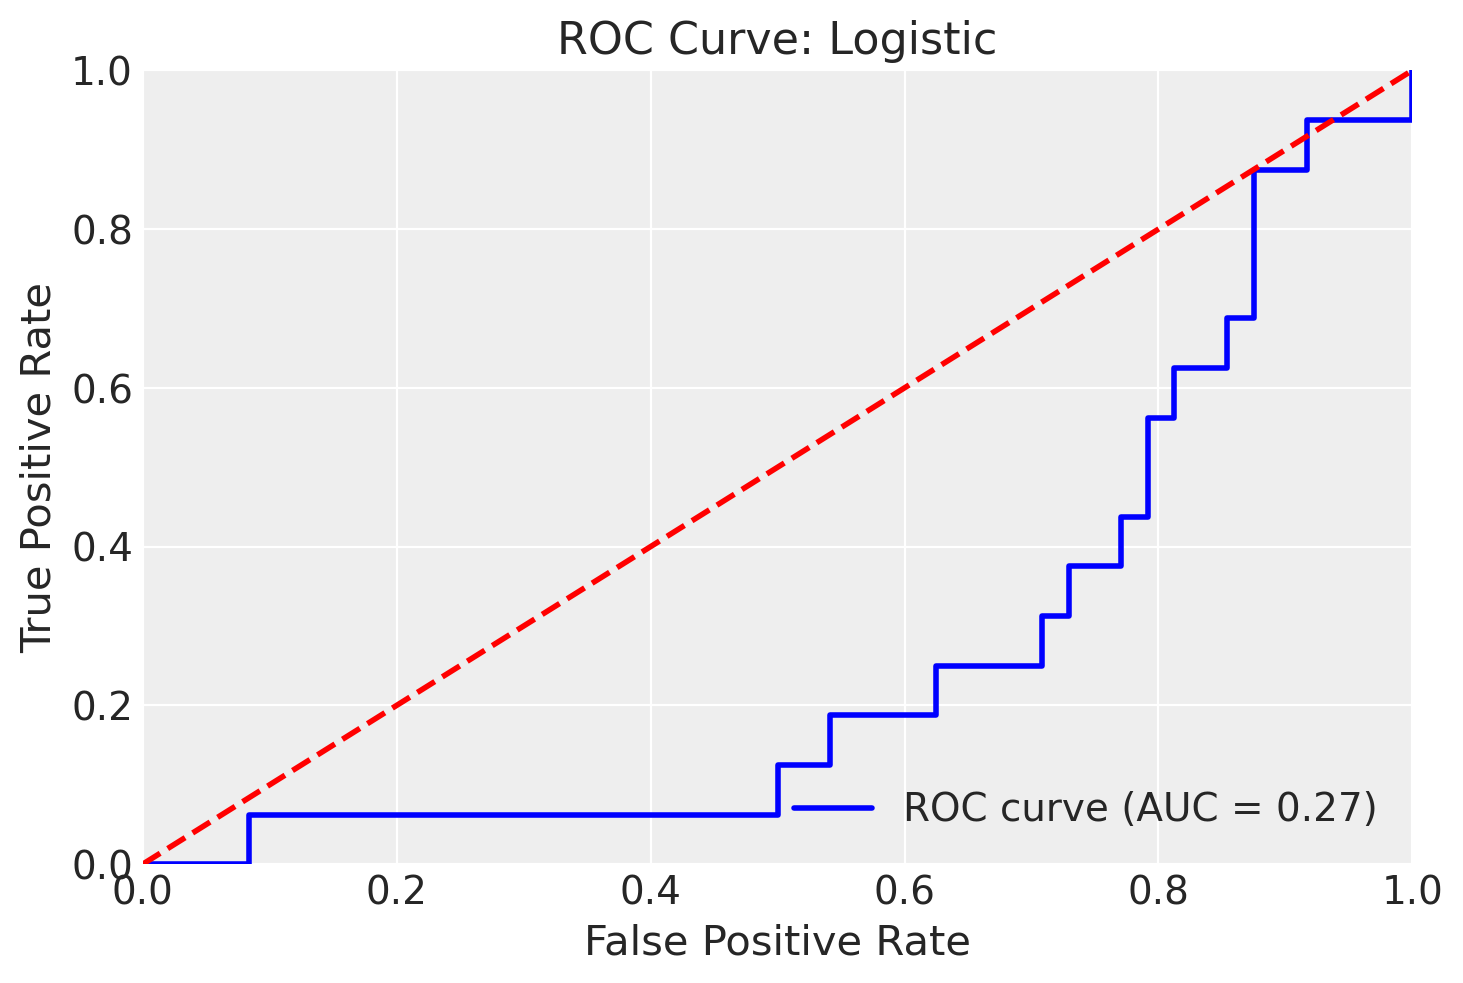

In [33]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Logistic')
plt.legend(loc="lower right")
plt.savefig('ROC_Curve_logit.png')
plt.show()

# Simple model 

In [ ]:
%%time
with pm.Model() as model_p:
    # Priors
    p = pm.Uniform('p', 0.0001, 0.1)
    alpha_1 = pm.Uniform('alpha_1', 0, 1)
    alpha_2 = pm.Uniform('alpha_2', 0, alpha_1)
    alpha_3 = pm.Uniform('alpha_3', 0, alpha_2)

    p_i = 1 - (1 - p)**t0 * (1 - alpha_1 * p)**t1 * (1 - alpha_2 * p)**t2 * (1 - alpha_3 * p)**t3

    
    p_i = pm.Deterministic('p_i', p_i)

    # Likelihood
    y_true = pm.Bernoulli('y_obs', p=p_i, observed=y)

    init = {'p': 0.01}

In [ ]:
%%time
with model_p:
    trace = pm.sampling.jax.sample_blackjax_nuts(draws=10000, tune=1000, chains=10, target_accept=0.95, initvals=init)

In [ ]:
with open('trace_sigmoid.pkl', 'wb') as f:
    pickle.dump(trace_sigmoid, f)

with open('trace_p.pkl', 'wb') as f:
    pickle.dump(trace, f)

In [ ]:
az.plot_posterior(trace, hdi_prob=.95);

In [ ]:
# p_samples = trace.posterior["p"].stack(sample=("chain", "draw")).values
# p_sample = np.random.choice(p_samples, size=5000)

samples = trace_sigmoid.posterior.stack(sample=("chain", "draw"))
p_list_df = pd.DataFrame(samples['p_i_sigmoid'].values)
p_list_df.head()

In [ ]:
p_list_df.columns = p_list_df.add_prefix('prob_').columns

concatenated_cols = pd.concat([df["experiment"], df["duration"], df["infected"]], axis=1)
p_list_df_concat = pd.concat([concatenated_cols, p_list_df], axis=1)

p_list_df_concat = p_list_df_concat.reset_index().drop(columns='index')

p_list_df_concat.head()

In [ ]:
means = round(p_list_df.apply(np.mean, axis=1), 4)
medians = round(p_list_df.apply(np.median, axis=1), 4)
sd = round(p_list_df.apply(np.std, axis=1), 4)
percentile_2 = round(p_list_df.apply(lambda x: np.percentile(x, 2.5), axis=1),4)
percentile_25 = round(p_list_df.apply(lambda x: np.percentile(x, 25), axis=1),4)
percentile_75 = round(p_list_df.apply(lambda x: np.percentile(x, 75), axis=1), 4)
percentile_97 = round(p_list_df.apply(lambda x: np.percentile(x, 97.5), axis=1), 4)

# Create a DataFrame with the results   
ID_probs_summary = pd.DataFrame({'mean': means, 'sd': sd, 'median': medians, '2.5%': percentile_2, '25%': percentile_25, '75%': percentile_75, '97.5%': percentile_97})
ID_probs_summary_concat = pd.concat([concatenated_cols, ID_probs_summary], axis=1)
ID_probs_summary_concat = ID_probs_summary_concat.reset_index().drop(columns='index')
ID_probs_summary_concat

In [ ]:
# Bernoulli draws from the estimated probabilities

simulations_bernoulli = p_list_df.map(lambda prob: np.random.binomial(1, prob))

In [ ]:
simulations_bernoulli.head()

In [ ]:
final_outcomes_majority = simulations_bernoulli.mode(axis=1)[0].astype(int)
final_outcomes_majority = pd.concat([concatenated_cols, final_outcomes_majority], axis=1)

final_outcomes_majority = final_outcomes_majority.reset_index().drop(columns='index')

final_outcomes_majority = final_outcomes_majority.rename(columns={0: 'estimated_class'})

final_outcomes_majority.head()

In [ ]:
concatenated_cols = pd.concat([df["experiment"], df["duration"], df["infected"]], axis=1)
concatenated_df = pd.concat([concatenated_cols, simulations_bernoulli], axis=1)

concatenated_df = concatenated_df.reset_index().drop(columns='index')

concatenated_df.head()

In [ ]:
cases_per_exp = concatenated_df.groupby(['experiment', 'duration']).sum().reset_index()

N = [6, 6, 6 , 6, 6, 5, 6,5, 6, 6, 6]

cases_per_exp.insert(2, 'N', N)

cases_per_exp = cases_per_exp.rename(columns={'infected': 'positives'})

cases_per_exp.to_csv('cases_per_experiment_logit.csv', index=False)

In [ ]:
cases_per_exp

In [ ]:
proportions = simulations_bernoulli.mean(axis=1)
df_proportions = pd.DataFrame(proportions, columns=['y_pred'])
df_proportions.insert(0, 'y_true', y)
p_list_df.insert(0, 'y_true', y)

In [ ]:
y_true = df_proportions['y_true']
y_pred = df_proportions['y_pred']

In [ ]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Logistic')
plt.legend(loc="lower right")
plt.savefig('ROC_Curve_logit.png')
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_true, y_pred)

plt.plot(recall, precision, marker='.', label ="Precision-Recall curve")
plt.legend()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR curve: Logistic')
plt.savefig('PR_Curve_logit.png')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Convert probabilities to binary predictions
y_pred_binary = [1 if p > 0.5 else 0 for p in y_pred]

# Now you can compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_binary)

# Visualize confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix: Logistic')
plt.savefig('confusion_matrix_logit.png')
plt.show()

In [ ]:
df_proportions['animal_ID'] = df['experiment'].astype(str) + '_' + df['duration'].astype(str) + '_' + df['Cap2'].astype(str)

In [ ]:
df_proportions.sort_values(by=['y_true', 'animal_ID'], ascending= True, inplace=True)
df_proportions.to_excel('Output2/df_proportions_seg_2m.xlsx', index=False)

In [ ]:
df_proportions = pd.read_excel("Output2/df_proportions_seg_2m.xlsx")

In [ ]:
# Créer une figure et un axe
fig, ax = plt.subplots(figsize = (20, 8))

# Tracer les points pour y_true et y_pred
ax.scatter(df_proportions['animal_ID'], df_proportions['y_true'], color='blue', label='Real observations')
ax.scatter(df_proportions['animal_ID'],df_proportions['y_pred'], color='red', label='Predicted probabilities')
ax.plot(df_proportions['animal_ID'], df_proportions['y_pred'], color='red')
ax.axhline(0.5, color='gray', lw=2, linestyle='--', label= 'y_pred=0.5')

# Tracer les boîtes entre y_true et y_pred
for i in range(len(df_proportions)):
    ax.plot([df_proportions['animal_ID'].iloc[i]]*2, [df_proportions['y_true'].iloc[i], df_proportions['y_pred'].iloc[i]], color='black')

# Définir les limites de l'axe des y
ax.set_ylim([0, 1])

for label in ax.get_xticklabels():
    label.set_rotation(90)

# Ajouter une légende
ax.legend()
plt.title("Real VS Predicted: segmented model, distance <= 2 m")
plt.xlabel("Animal Identifier")

plt.show()

# Exposition time estimation

In [ ]:
s_sample = np.random.choice(p_sample, size=10)

time = np.arange(1, 1441)



fig, ax = plt.subplots(figsize=(10,9))

ax.set_ylim([0, 1])
ax.axhline(0.5, color='gray', linestyle='--', label= 'P=0.5')
ax.axhline(0.95, color='red', linestyle='--', label= 'P=0.95')

for s in p_sample:
    F = 1 - (1 - s) ** time
    ax.plot(time, F, label=f'p={round(s, 4)}')
    
plt.legend()
plt.xlabel('Time')
plt.ylabel('transmission probability (P)')
plt.title('Exposition time estimation, fixed distance = 2m')
plt.show()

In [ ]:
y_true = simulations['y_true']

In [ ]:
def plot_roc_curve(true_y, y_prob):

    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    auc = roc_auc_score(true_y, y_prob)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc:0.4f})')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve : segmented distance = 2m')
    plt.legend(loc="lower right")

In [ ]:
aucs = []

# Boucle sur chaque colonne d'estimations
for col in simulations.columns[1:] : # Commencer à partir de la deuxième colonne car la première est y_true
    y_pred = simulations[col]
    auc = roc_auc_score(y_true, y_pred)
    aucs.append(auc)


In [ ]:
mean_auc = np.mean(aucs)
median_auc = np.median(aucs)

print("mean auc:", mean_auc)
print("median auc:", median_auc)

q1 = np.quantile(aucs, 0.25)
q3 = np.quantile(aucs, 0.75)

if q3 == q1: 
   print("Not enough data")
else:
   iqr = q3 - q1  
   lower = q1 - 1.5 * iqr
   upper = q3 + 1.5 * iqr 
   conf_interval = (lower, upper)

   print(conf_interval)

In [ ]:
# Trouver l'indice du maximum dans la liste d'AUC
indice_max_auc = np.argmax(aucs)

# Récupérer la colonne d'estimation avec le maximum d'AUC
col_max_auc = simulations.columns[indice_max_auc + 1]  # +1 pour compenser la première colonne (y_true)

# Afficher la colonne d'estimation avec le maximum d'AUC
print(f"La colonne avec le maximum d'AUC est : {col_max_auc}")

In [ ]:
y_pred = simulations['y_pred1']

In [ ]:
plot_roc_curve(y_true, y_pred)

In [ ]:
# Plot histogram  
plt.hist(y_true, bins=30, density=True)
plt.hist(y_pred, bins=30, density=True)
plt.vlines(y_pred.mean(), 0, 0.4, colors='r') 

plt.xlabel('Sampled θ')  
plt.ylabel('Density')
plt.title('Posterior Distribution')
   
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_true, y_pred > 0.5) 
print(accuracy)

In [ ]:
from sklearn.metrics import precision_score, recall_score  

precision = precision_score(y_true, y_pred > 0.5)  
recall = recall_score(y_true, y_pred > 0.5)

print(precision, recall)

In [ ]:
from sklearn.calibration import CalibrationDisplay

CalibrationDisplay.from_predictions(y_true, y_pred)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_true, y_pred)

plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

specificity = 1 - fpr
plt.plot(specificity, tpr, color='green', label='Sensitivity')
plt.xlabel('Specificity')
plt.ylabel('Sensitivity')
plt.title('Sensitivity/Specificity Curve')
plt.legend(loc="lower right")
plt.show()

# Posterior analysis

In [ ]:
az.plot_trace(trace, combined=True);

In [ ]:
az.summary(trace, round_to=6)

In [ ]:
pm.model_to_graphviz(model)

In [ ]:
az.plot_energy(trace);

# Model log-likelihood

In [ ]:
with model:
    pm.compute_log_likelihood(trace)

In [ ]:
model_loo = az.loo(trace)

model_loo

In [ ]:
model_waic = az.waic(trace)

model_waic

In [ ]:
# Generate posterior predictive samples
with model:
    pm.sample_posterior_predictive(trace, random_seed=42, extend_inferencedata=True)

In [ ]:
trace.posterior_predictive

In [ ]:
az.plot_ppc(trace, num_pp_samples=1000, kind = 'kde', group="posterior");

In [ ]:
az.plot_ppc(trace, num_pp_samples=1000, kind = 'cumulative');

In [ ]:
az.plot_ppc(trace, num_pp_samples=5, kind = 'scatter');

In [ ]:
az.plot_autocorr(trace);

In [ ]:
# Gelman-Rubin convergence diagnostic
r_hat = az.rhat(trace)
print(r_hat)

In [ ]:
ess = az.ess(trace)

In [ ]:
az.plot_ess(trace, kind="evolution");

In [ ]:
total_ess = ess["p"].sum().values
print(f"Total effective sample size for p: {float(total_ess):.2f}")